# Using Geopandas

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import fiona
import rasterio
import xarray as xr

In [10]:
#Load raster
# wpgt = xr.open_dataarray("/g/data/v45/la6889/Calculations/Baseline_SST_1979-2008.nc", autoclose = True)
# wpgt.isel(season = 0).rio.to_raster('test.tif')
x = xr.open_rasterio(filename = r"/g/data/v45/la6889/Calculations/Baseline_SST_1979-2008.nc")
# x[0].rio.to_raster("test.tif")
# wpgt
#Try CRS EPSG:4326
x.crs()

AttributeError: 'DataArray' object has no attribute 'crs'

In [66]:
# rasterIce = rasterio.features.rasterize([x.geometry, 1] for i, x in )
y = rasterio.open("test.tif")
y_r = y.read()
y_r.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

AttributeError: 'DatasetReader' object has no attribute 'plot'

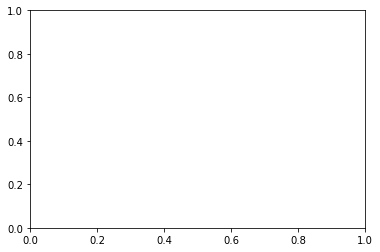

In [69]:
plt.subplot(1, 1, 1)
y.plot()

In [6]:
#Load shapefile
gf = gpd.read_file(r'/g/data/v45/la6889/GIS_DataBase/Shapefiles/SOregions.shp')
#Check content of shapefile
gf.head()

,name,sector,zone,fill,geometry
0,AOA,Atlantic,Antarctic,#BCECFEFF,"POLYGON ((-2891646.910 1737476.753, -2906527.1..."
1,AON,Atlantic,Northern,#054e70FF,"POLYGON ((2613012.979 4525871.241, 2602872.922..."
2,AOS,Atlantic,Subantarctic,#1094AFFF,"POLYGON ((1842391.575 3191115.815, 1832255.865..."
3,AOT,Atlantic,None,None,"POLYGON ((-3353009.432 1723415.613, -3368360.3..."
4,CIA,CentralIndian,Antarctic,#FFFFFFFF,"POLYGON ((279139.204 483483.283, 290257.638 50..."


<AxesSubplot:>

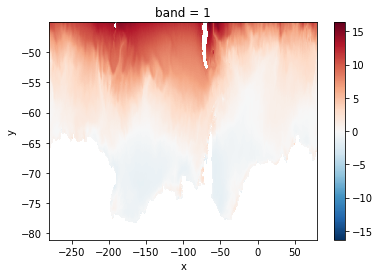

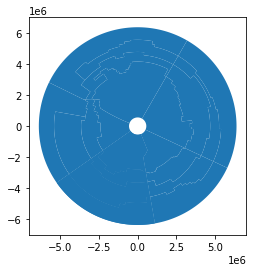

In [7]:
x[0].plot()
gf.plot()

In [13]:
#Slicing data
gf.iloc[3:5]

,name,sector,zone,fill,geometry
3,AOT,Atlantic,None,None,"POLYGON ((-3353009.432 1723415.613, -3368360.3..."
4,CIA,CentralIndian,Antarctic,#FFFFFFFF,"POLYGON ((279139.204 483483.283, 290257.638 50..."


In [40]:
#Checking CRS
gf.crs

<Projected CRS: EPSG:6932>
Name: WGS 84 / NSIDC EASE-Grid 2.0 South
Axis Info [cartesian]:
- X[north]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - south of 0°N
- bounds: (-180.0, -90.0, 180.0, 0.0)
Coordinate Operation:
- name: US NSIDC EASE-Grid 2.0 South
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
#Query column for a value of interest - Note that entire query needs to be inside quotation marks and then again quotation marks are used for strings
gf.query('zone == "Antarctic"')

,name,sector,zone,fill,geometry
0,AOA,Atlantic,Antarctic,#BCECFEFF,"POLYGON ((-2891646.910 1737476.753, -2906527.1..."
4,CIA,CentralIndian,Antarctic,#FFFFFFFF,"POLYGON ((279139.204 483483.283, 290257.638 50..."
8,EIA,EastIndian,Antarctic,#EAFAFFFF,"POLYGON ((3048452.332 -1421516.668, 3044304.41..."
12,EPA,EastPacific,Antarctic,#FFFFFFFF,"POLYGON ((-457314.899 -320215.339, -475594.187..."
16,WPA,WestPacific,Antarctic,#016074FF,"POLYGON ((533521.269 -3025749.472, 524717.476 ..."
17,WPA,WestPacific,Antarctic,#BCECFEFF,"POLYGON ((533521.269 -3025749.472, 524717.476 ..."


In [20]:
#Complex queries can be done concatenating the query function multiple times
gf.query('zone == "Antarctic"').query('sector == "WestPacific"')

,name,sector,zone,fill,geometry
16,WPA,WestPacific,Antarctic,#016074FF,"POLYGON ((533521.269 -3025749.472, 524717.476 ..."
17,WPA,WestPacific,Antarctic,#BCECFEFF,"POLYGON ((533521.269 -3025749.472, 524717.476 ..."


In [21]:
#Basic statistics given when using describe function
gf.zone.describe()

count            18
unique            3
top       Antarctic
freq              6
Name: zone, dtype: object

In [22]:
#Unique values for a column can be obtained with unique
gf.zone.unique() #It matches the above information of three unique values

array(['Antarctic', 'Northern', 'Subantarctic', None], dtype=object)

In [24]:
#Grouping is also possible
results = gf.groupby('sector').zone.describe()
results

,count,unique,top,freq
sector,,,,
Atlantic,3,3,Antarctic,1
CentralIndian,3,3,Antarctic,1
EastIndian,3,3,Antarctic,1
EastPacific,3,3,Antarctic,1
WestPacific,6,3,Antarctic,2


<AxesSubplot:xlabel='sector'>

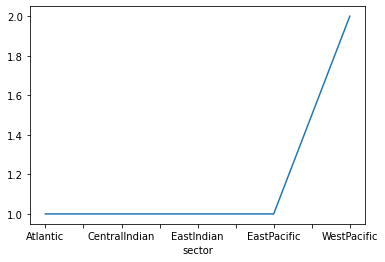

In [33]:
#Plotting above results
results.freq.plot()

<AxesSubplot:xlabel='sector'>

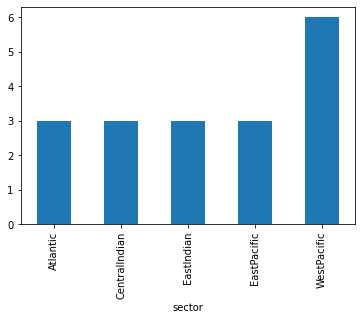

In [39]:
#Using groups to count zones per sector and plotting as bars
gf.groupby('sector').zone.count().sort_values().plot.bar()

<AxesSubplot:>

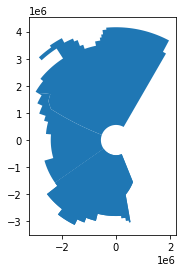

In [29]:
#Create a bounding box to subset data
ymin, ymax, xmin, xmax = [-461547.78184981, 2637584.92643165, -2219332.22836696, -136922.07379919]
#Subset data that is located within limits of bounding box
subset = gf.cx[xmin:xmax, ymin:ymax]
#Plot result
subset.plot()

In [24]:
#Changing crs
subset = subset.to_crs(epsg=32610)
subset.area*1e-6

0     1.405971e+07
12    3.679846e+06
16    5.844277e+06
17    5.844277e+06
dtype: float64

In [13]:
import shapely

In [31]:
coords = [(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)]
polygon = shapely.geometry.Polygon(coords)
polygon_gp = gpd.GeoDataFrame(geometry = [polygon], crs = {'init': 'epsg:6932'})
polygon_gp

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,geometry
0,"POLYGON ((-2219332.228 -461547.782, -2219332.2..."


In [34]:
# gpd.sjoin(subset, polygon_gp, how = 'inner', op = 'within')


<Projected CRS: EPSG:6932>
Name: WGS 84 / NSIDC EASE-Grid 2.0 South
Axis Info [cartesian]:
- X[north]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - south of 0°N
- bounds: (-180.0, -90.0, 180.0, 0.0)
Coordinate Operation:
- name: US NSIDC EASE-Grid 2.0 South
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich